In [1]:
%matplotlib inline
 
import matplotlib.pyplot as plt
import numpy as np
import os
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [84]:
import joblib
from skimage.io import imread
from skimage.transform import resize
 
def resize_all(src, pklname, include, width=150, height=None, count=100):
    """
    load images from path, resize them and write them as arrays to a dictionary, 
    together with labels and metadata. The dictionary is written to a pickle file 
    named '{pklname}_{width}x{height}px.pkl'.
     
    Parameter
    ---------
    src: str
        path to data
    pklname: str
        path to output file
    width: int
        target width of the image in pixels
    include: set[str]
        set containing str
    """
     
    height = height if height is not None else width
     
    data = dict()
    data['description'] = 'resized ({0}x{1}) beverage images in rgb'.format(int(width), int(height))
    data['label'] = []
    data['filename'] = []
    data['data'] = []   
     
    pklname = f"{pklname}_{width}x{height}px.pkl"
 
    # read all images in PATH, resize and write to DESTINATION_PATH
    for subdir in os.listdir(src):
        if subdir in include:
            print(subdir)
            current_path = os.path.join(src, subdir)
            i = 0
            for file in os.listdir(current_path):
                if file[-3:] in {'jpg', 'png'} or file[-4:] in {'jpeg'}:
                    im = imread(os.path.join(current_path, file))
                    im = resize(im, (width, height)) #[:,:,::-1]
                    if(im.shape != (width, height, 3)):
                        continue
                    if(i >= count):
                        break
                    data['label'].append(subdir)
                    data['filename'].append(file)
                    data['data'].append(im)
                    i += 1
 
        joblib.dump(data, pklname)

In [85]:
data_path = fr'Drinks/train'
os.listdir(data_path)

['beer', 'cocktail', 'coffee', 'juice', 'tea', 'wine']

In [86]:
base_name = 'beverages'
width = 120
include = {'beer', 'coffee'}
count = 300

In [87]:
resize_all(src=data_path, pklname=base_name, width=width, include=include, count=count)

beer
coffee


In [88]:
from collections import Counter
 
data = joblib.load(f'{base_name}_{width}x{width}px.pkl')
 
print('number of samples: ', len(data['data']))
print('keys: ', list(data.keys()))
print('description: ', data['description'])
print('image shape: ', data['data'][0].shape)
print('labels:', np.unique(data['label']))
 
Counter(data['label'])

number of samples:  600
keys:  ['description', 'label', 'filename', 'data']
description:  resized (120x120) beverage images in rgb
image shape:  (120, 120, 3)
labels: ['beer' 'coffee']


Counter({'beer': 300, 'coffee': 300})

(120, 120, 3)

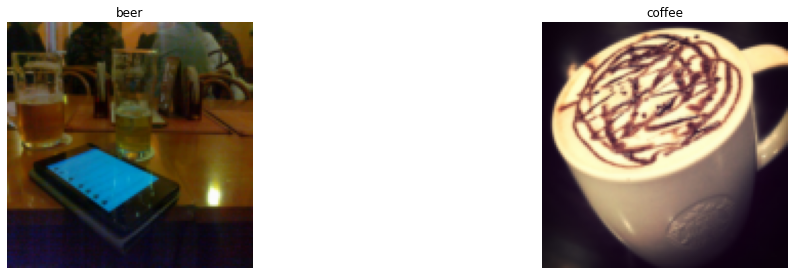

In [89]:
# use np.unique to get all unique values in the list of labels
labels = np.unique(data['label'])
 
# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
 
# make a plot for every label (equipment) type. The index method returns the 
# index of the first item corresponding to its search string, label in this case
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
     
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)
    
    
data['data'][0].shape

In [90]:
X = np.array(data['data'])
print(X.shape)
y = np.array(data['label'])
print(y.shape)

(600, 120, 120, 3)
(600,)


In [91]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

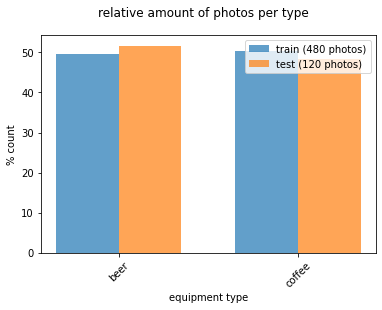

In [92]:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('equipment type')
    plt.ylabel(ylabel_text)
 
plt.suptitle('relative amount of photos per type')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend([
    'train ({0} photos)'.format(len(y_train)), 
    'test ({0} photos)'.format(len(y_test))
]);

In [93]:
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale

In [94]:
from sklearn.base import BaseEstimator, TransformerMixin
 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self 
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
     
 
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [95]:
from sklearn.linear_model import SGDClassifier 
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
import skimage
 
# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(8, 8), 
    cells_per_block=(4,4), 
    orientations=9, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()
 
# call fit_transform on each transform converting X_train step by step
X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train_gray)
X_train_prepared = scalify.fit_transform(X_train_hog)
 
print(X_train_prepared.shape)
print(len(X_train_prepared[0]))

(480, 20736)
20736


In [96]:
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3, loss="hinge")
sgd_clf.fit(X_train_prepared, y_train)


SGDClassifier(random_state=42)

In [97]:
X_test_gray = grayify.transform(X_test)
X_test_hog = hogify.transform(X_test_gray)
X_test_prepared = scalify.transform(X_test_hog)

In [98]:
y_pred = sgd_clf.predict(X_test_prepared)
print(y_pred.shape)
print(y_test.shape)
print(np.array(y_pred == y_test)[:25])
print('')
print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))

(120,)
(120,)
[ True False  True  True  True  True  True  True False  True  True False
 False  True False False  True  True  True  True  True  True  True False
  True]

Percentage correct:  70.0


In [99]:
import pandas as pd

In [100]:
from sklearn.metrics import confusion_matrix
cmx = confusion_matrix(y_test, y_pred)
cmx

array([[46, 16],
       [20, 38]], dtype=int64)


 ['beer', 'coffee']


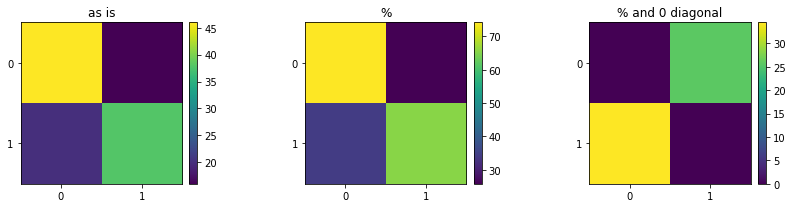

In [101]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
 
def plot_confusion_matrix(cmx, vmax1=None, vmax2=None, vmax3=None):
    cmx_norm = 100*cmx / cmx.sum(axis=1, keepdims=True)
    cmx_zero_diag = cmx_norm.copy()
 
    np.fill_diagonal(cmx_zero_diag, 0)
 
    fig, ax = plt.subplots(ncols=3)
    fig.set_size_inches(12, 3)
    [a.set_xticks(range(len(cmx)+1)) for a in ax]
    [a.set_yticks(range(len(cmx)+1)) for a in ax]
         
    im1 = ax[0].imshow(cmx, vmax=vmax1)
    ax[0].set_title('as is')
    im2 = ax[1].imshow(cmx_norm, vmax=vmax2)
    ax[1].set_title('%')
    im3 = ax[2].imshow(cmx_zero_diag, vmax=vmax3)
    ax[2].set_title('% and 0 diagonal')
 
    dividers = [make_axes_locatable(a) for a in ax]
    cax1, cax2, cax3 = [divider.append_axes("right", size="5%", pad=0.1) 
                        for divider in dividers]
 
    fig.colorbar(im1, cax=cax1)
    fig.colorbar(im2, cax=cax2)
    fig.colorbar(im3, cax=cax3)
    fig.tight_layout()
     
plot_confusion_matrix(cmx)
 
# the types appear in this order
print('\n', sorted(np.unique(y_test)))

In [102]:
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import datasets
from sklearn import svm

Support vector classification: Linear, Polynomial, Radial Basis Function

In [103]:
X = np.array(data['data'])
y = np.array(data['label'])
lin_clf = svm.SVC(kernel='linear', C=1)
poly_clf = svm.SVC(kernel='poly')
rbf_clf = svm.SVC(kernel='rbf')

test_gray = grayify.transform(X)
test_hog = hogify.transform(test_gray)
test_prepared = scalify.transform(test_hog)


In [104]:
# We give cross_val_score a model, the entire data set and its "real" values, and the number of folds:
scores = cross_val_score(sgd_clf, test_prepared, y, cv=10)

# Print the accuracy for each fold:
print(scores)

# And the mean accuracy of all the folds:
print(scores.mean())

[0.65       0.7        0.73333333 0.75       0.63333333 0.8
 0.81666667 0.78333333 0.83333333 0.85      ]
0.755


In [105]:
# We give cross_val_score a model, the entire data set and its "real" values, and the number of folds:
scores = cross_val_score(lin_clf, test_prepared, y, cv=10)

# Print the accuracy for each fold:
print(scores)

# And the mean accuracy of all the folds:
print(scores.mean())

[0.73333333 0.7        0.65       0.73333333 0.61666667 0.8
 0.85       0.78333333 0.81666667 0.85      ]
0.7533333333333332


In [106]:
# We give cross_val_score a model, the entire data set and its "real" values, and the number of folds:
scores = cross_val_score(poly_clf, test_prepared, y, cv=10)

# Print the accuracy for each fold:
print(scores)

# And the mean accuracy of all the folds:
print(scores.mean())

[0.53333333 0.53333333 0.55       0.58333333 0.5        0.6
 0.56666667 0.58333333 0.56666667 0.61666667]
0.5633333333333332


In [107]:
# We give cross_val_score a model, the entire data set and its "real" values, and the number of folds:
scores = cross_val_score(rbf_clf, test_prepared, y, cv=10)

# Print the accuracy for each fold:
print(scores)

# And the mean accuracy of all the folds:
print(scores.mean())

[0.73333333 0.81666667 0.76666667 0.76666667 0.75       0.8
 0.91666667 0.71666667 0.86666667 0.85      ]
0.7983333333333332


In [108]:
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier

In [109]:
neigh_clf = KNeighborsClassifier(n_neighbors=10)


In [110]:
scores = cross_val_score(neigh_clf, test_prepared, y, cv=10)

# Print the accuracy for each fold:
print(scores)

# And the mean accuracy of all the folds:
print(scores.mean())

[0.68333333 0.61666667 0.71666667 0.71666667 0.63333333 0.71666667
 0.75       0.73333333 0.78333333 0.68333333]
0.7033333333333334
